In [38]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

### Utility Functions

In [85]:
SENSORS = [
    'light', 'temp', 'humid', 'weight', 'smoist', 'level',
    'level_raw', 'light_raw_1', 'light_raw_2',
    'temp_raw_1', 'temp_raw_2', 'humid_raw_1', 'humid_raw_2',
    'weight_raw_1', 'weight_raw_2', 'smoist_raw_1', 'smoist_raw_2']
ACTUATORS = ['led', 'fan', 'wpump']

In [86]:
def format_time_df(df, start_time=None):
    time_column = list(df['unix_time'])
    if start_time is None:
        start_time = time_column[0]
    time_column = [(t - start_time) / 3600.0 for t in time_column]

    df.insert(0, 'monitor_time_hrs', time_column)
    return df

In [88]:
# Actuators of interest for each sensor
sensors_to_actuators = {
    'light': ['led'],
    'temp': ['led', 'fan'],
    'humid': ['fan', 'wpump'],
    'weight': ['wpump'],
    'smoist': ['fan', 'wpump'],
    'level': ['wpump'],
    'level_raw': ['wpump'],
    'light_raw_1': ['led'],
    'light_raw_2': ['led'],
    'temp_raw_1': ['led', 'fan'],
    'temp_raw_2': ['led', 'fan'],
    'humid_raw_1': ['fan', 'wpump'],
    'humid_raw_2': ['fan', 'wpump'],
    'weight_raw_1': ['wpump'],
    'weight_raw_2': ['wpump'],
    'smoist_raw_1': ['fan', 'wpump'],
    'smoist_raw_2': ['fan', 'wpump']
}

In [94]:
# Axis labels for sensors
sensors_to_labels = {
    'light': 'Light Level',
    'temp': 'Temperature (degrees Celsius)',
    'humid': 'Humidity (%)',
    'weight': 'Greenhouse Weight (g)',
    'smoist': 'Soil Moisture',
    'level': 'Reservoir Level (mL)',
    'level_raw': 'Reservoir Level (mL)',
    'light_raw_1': '[RAW] Light Level 1',
    'light_raw_2': '[RAW] Light Level 2',
    'temp_raw_1': '[RAW] Temperature 1 (degrees Celsius)',
    'temp_raw_2': '[RAW] Temperature 2 (degrees Celsius)',
    'humid_raw_1': '[RAW] Humidity 1 (%)',
    'humid_raw_2': '[RAW] Humidity 2 (%)',
    'weight_raw_1': '[RAW] Greenhouse Weight 1 (g)',
    'weight_raw_2': '[RAW] Greenhouse Weight 2 (g)',
    'smoist_raw_1': '[RAW] Soil Moisture 1',
    'smoist_raw_2': '[RAW] Soil Moisture 2'
}

In [90]:
# Plot colors for actuators
actuators_to_colors = {
    'led': 'red',
    'fan': 'green',
    'wpump': 'blue'
}

In [45]:
# Get times when actuators were activated/deactivated
def get_actuator_activations(
    times: list[float],
    values: list) -> tuple[list[float], list[float]]:
    on = []
    off = []
    prev = None
    curr = None
    for (t, v) in zip(times, values):
        curr = v
        if prev is None:
            if curr:
                on.append(t)
            else:
                off.append(t)
        else:
            if isinstance(curr, bool):
                if prev != curr:
                    if curr:
                        on.append(t)
                    else:
                        off.append(t)
            elif isinstance(curr, int) or isinstance(curr, float):
                if (prev == 0 and curr != 0) or (prev != 0 and curr == 0):
                    if curr:
                        on.append(t)
                    else:
                        off.append(t)
        prev = curr
    return on, off

## Visualizing Data

In [46]:
log_file_name = "~/15-482/GrowPeriodA/grow_period_A_log.csv"
df = pd.read_csv(log_file_name)
df

,unix_time,light,temp,humid,weight,smoist,level,level_raw,light_raw_1,light_raw_2,...,humid_raw_1,humid_raw_2,weight_raw_1,weight_raw_2,smoist_raw_1,smoist_raw_2,fan,wpump,led,camera
0,1.760058e+09,868.0,24.0,71.5,649.769989,654.5,70.0,70.0,911,825,...,77,66,346.429993,303.339996,635,674,False,False,200,/home/robotanist/User/images/image_1760057509....
1,1.760058e+09,25.0,24.0,72.0,715.299988,656.0,51.0,51.0,10,40,...,79,65,374.750000,340.549988,635,677,False,True,20,/home/robotanist/User/images/image_1760057509....
2,1.760058e+09,557.5,24.0,72.5,734.239990,656.0,70.0,70.0,606,509,...,80,65,385.299988,348.940002,634,678,False,False,60,/home/robotanist/User/images/image_1760057531....
3,1.760058e+09,556.5,24.5,72.0,734.220001,656.0,70.0,70.0,605,508,...,81,63,387.010010,347.209991,634,678,False,False,60,/home/robotanist/User/images/image_1760057531....
4,1.760058e+09,557.5,24.0,72.5,734.290009,655.5,70.0,70.0,605,510,...,80,65,388.059998,346.230011,634,677,False,False,60,/home/robotanist/User/images/image_1760057548....
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208770,1.762299e+09,641.5,24.0,87.0,1151.859985,676.5,46.0,46.0,926,357,...,91,83,631.359985,520.500000,665,688,False,False,255,/home/robotanist/User/images/image_1762263645....
208771,1.762299e+09,640.0,24.0,86.5,1151.780029,676.0,46.0,46.0,925,355,...,91,82,631.340027,520.440002,664,688,False,False,255,/home/robotanist/User/images/image_1762263645....
208772,1.762299e+09,640.5,24.0,87.0,1151.760010,676.0,46.0,46.0,925,356,...,91,83,631.299988,520.460022,664,688,False,False,255,/home/robotanist/User/images/image_1762263645....
208773,1.762299e+09,641.0,24.0,83.5,1151.819946,675.5,46.0,46.0,925,357,...,86,81,631.349976,520.469971,664,687,False,False,255,/home/robotanist/User/images/image_1762263645....


In [47]:
start_time = list(df['unix_time'])[0]

In [48]:
formated_df = format_time_df(df)
formated_df

,monitor_time_hrs,unix_time,light,temp,humid,weight,smoist,level,level_raw,light_raw_1,...,humid_raw_1,humid_raw_2,weight_raw_1,weight_raw_2,smoist_raw_1,smoist_raw_2,fan,wpump,led,camera
0,0.000000,1.760058e+09,868.0,24.0,71.5,649.769989,654.5,70.0,70.0,911,...,77,66,346.429993,303.339996,635,674,False,False,200,/home/robotanist/User/images/image_1760057509....
1,0.003002,1.760058e+09,25.0,24.0,72.0,715.299988,656.0,51.0,51.0,10,...,79,65,374.750000,340.549988,635,677,False,True,20,/home/robotanist/User/images/image_1760057509....
2,0.005971,1.760058e+09,557.5,24.0,72.5,734.239990,656.0,70.0,70.0,606,...,80,65,385.299988,348.940002,634,678,False,False,60,/home/robotanist/User/images/image_1760057531....
3,0.009000,1.760058e+09,556.5,24.5,72.0,734.220001,656.0,70.0,70.0,605,...,81,63,387.010010,347.209991,634,678,False,False,60,/home/robotanist/User/images/image_1760057531....
4,0.011946,1.760058e+09,557.5,24.0,72.5,734.290009,655.5,70.0,70.0,605,...,80,65,388.059998,346.230011,634,677,False,False,60,/home/robotanist/User/images/image_1760057548....
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208770,622.712524,1.762299e+09,641.5,24.0,87.0,1151.859985,676.5,46.0,46.0,926,...,91,83,631.359985,520.500000,665,688,False,False,255,/home/robotanist/User/images/image_1762263645....
208771,622.715550,1.762299e+09,640.0,24.0,86.5,1151.780029,676.0,46.0,46.0,925,...,91,82,631.340027,520.440002,664,688,False,False,255,/home/robotanist/User/images/image_1762263645....
208772,622.718605,1.762299e+09,640.5,24.0,87.0,1151.760010,676.0,46.0,46.0,925,...,91,83,631.299988,520.460022,664,688,False,False,255,/home/robotanist/User/images/image_1762263645....
208773,622.721632,1.762299e+09,641.0,24.0,83.5,1151.819946,675.5,46.0,46.0,925,...,86,81,631.349976,520.469971,664,687,False,False,255,/home/robotanist/User/images/image_1762263645....


In [95]:
def plot_sensor(
        df, sensor: str,
        actuators=None,
        time_frame=(None, None)):
    
    # Getting Time Frame
    T = df['monitor_time_hrs'].to_numpy()
    S = df[sensor].to_numpy()
    A = df[ACTUATORS]
    
    start_time, end_time = time_frame
    start_time = T[0] if start_time is None else start_time
    end_time = T[-1] if end_time is None else end_time
    if start_time > end_time:
        print(f"FAILURE: Start time of {start_time} is greater than end time of {end_time}")
        return
    if start_time > T[-1]:
        print(f"FAILURE: Start time of {start_time} is greater than t_f={T[-1]}")
        return
    if end_time < T[0]:
        print(f"FAILURE: End time of {end_time} is less than t_0={T[0]}")
        return
    
    t_indices = np.where((start_time <= T) & (T <= end_time))[0]
    X = T[t_indices]
    Y = S[t_indices]
    A = A.iloc[t_indices]

    ELAPSED_TIME = end_time - start_time
    if ELAPSED_TIME > 60:
        X /= 24.0 # Hours -> Days 

    if actuators is None:
        actuators = sensors_to_actuators[sensor]  # Default

    plt.plot(X, Y, 'k', linewidth=1)

    for actuator in actuators:
        color = actuators_to_colors[actuator]
        if actuator == 'led':
            plt.plot(X, A[actuator].to_numpy(),
                     color=color, linewidth=0.5, label=f'{actuator} value')
        else:
            on_times, off_times = get_actuator_activations(X, A[actuator].to_numpy())
            first = True
            for t in on_times:
                if first:
                    plt.axvline(x=t, color=color, linestyle='--', linewidth=0.5,
                            label=f'{actuator} turned on')
                else:
                    plt.axvline(x=t, color=color, linestyle='--', linewidth=0.5)
                first = False
            first = True
            for t in off_times:
                if first:
                    plt.axvline(x=t, color=color, linestyle=':', linewidth=0.5,
                            label=f'{actuator} turned off')
                else:
                    plt.axvline(x=t, color=color, linestyle=':', linewidth=0.5)
                first = False

    if ELAPSED_TIME > 60:
        plt.xlabel('Days Passed')
    else:
        plt.xlabel('Hours Passed')
    plt.ylabel(sensors_to_labels[sensor])
    plt.title(f'Plot of {sensor} over time')
    plt.legend()
    plt.show()

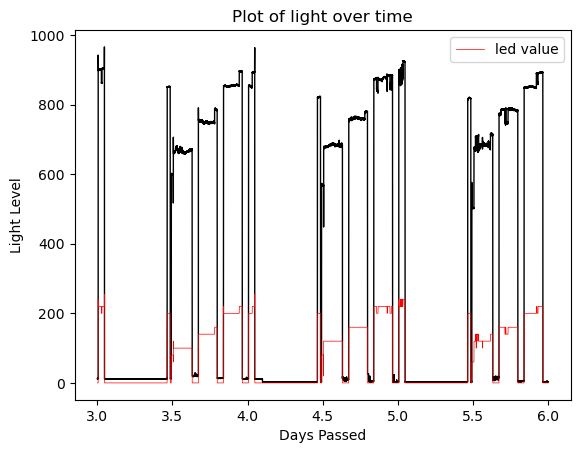

In [98]:
plot_sensor(formated_df, 'light', time_frame=(24*3,24*6))

/var/folders/28/bb_274yx6z37p5pzp7kfy8880000gn/T/ipykernel_26849/3298199016.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


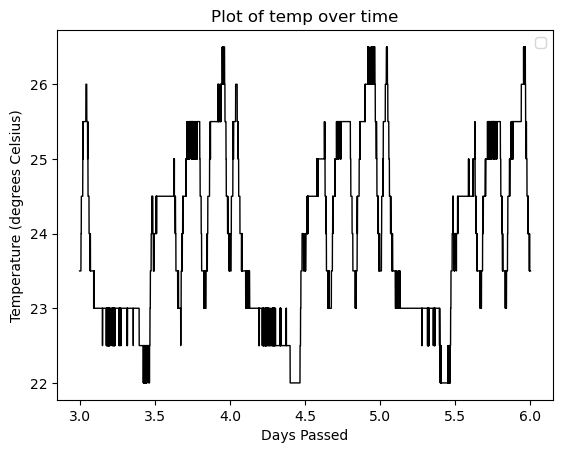

In [78]:
plot_sensor(formated_df, 'temp', time_frame=(24*3,24*6), actuators=[])

/var/folders/28/bb_274yx6z37p5pzp7kfy8880000gn/T/ipykernel_26849/3298199016.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


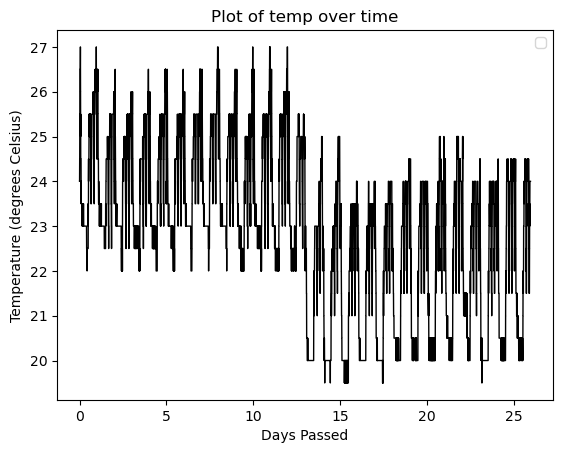

In [74]:
plot_sensor(formated_df, 'temp', actuators=[])

/var/folders/28/bb_274yx6z37p5pzp7kfy8880000gn/T/ipykernel_26849/3298199016.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


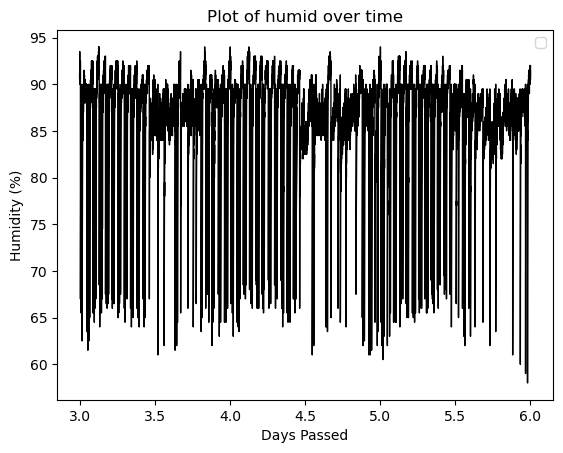

In [80]:
plot_sensor(formated_df, 'humid', actuators=[], time_frame=(24*3,24*6))

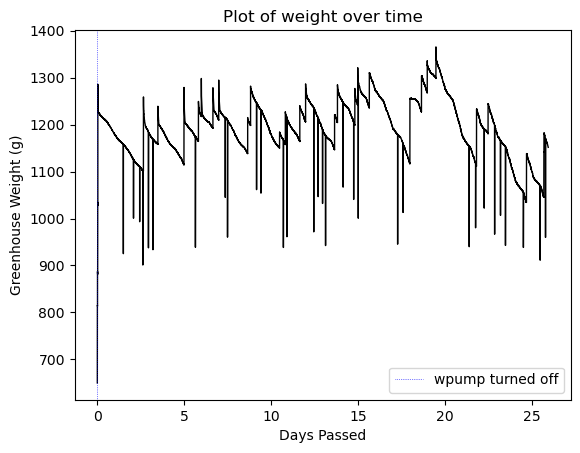

In [81]:
plot_sensor(formated_df, 'weight')

/var/folders/28/bb_274yx6z37p5pzp7kfy8880000gn/T/ipykernel_26849/3298199016.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


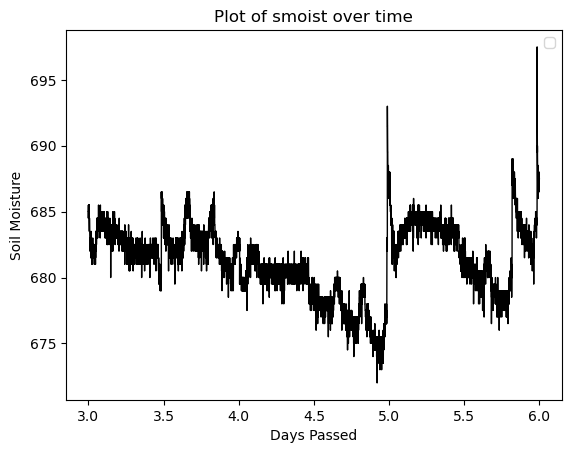

In [83]:
plot_sensor(formated_df, 'smoist', time_frame=(24*3,24*6), actuators=[])

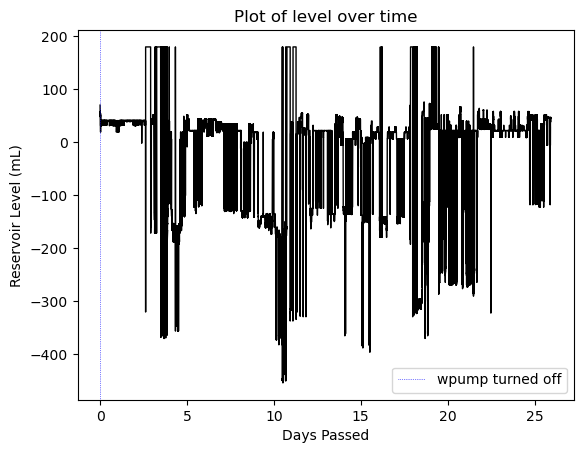

In [84]:
plot_sensor(formated_df, 'level')